In [2]:
import numpy as np
import cv2
from scipy.spatial import distance
from matplotlib import pyplot as plt

In [11]:
# Загрузка изображения и преобразование его в серую шкалу
image_path = 'image/8.0.png'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Применение гауссова размытия для снижения шума перед обнаружением кругов
blurred = cv2.GaussianBlur(gray, (9, 9), 0)

Средний цвет центральной части круга: (235.62231224680585, 222.9074478030539, 203.68712994702398, 0.0)


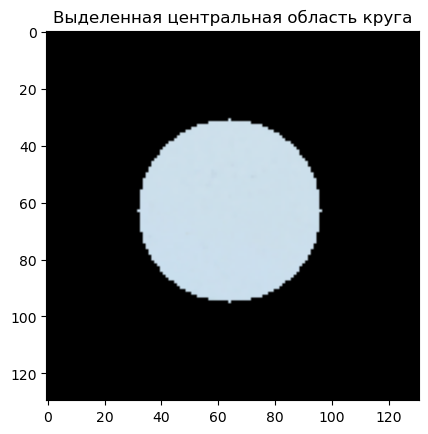

In [12]:
# Обнаружение кругов на изображении
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=20, maxRadius=200)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        # Создание маски для выделения центральной части круга
        # Мы установим радиус центральной части как 50% от общего радиуса
        inner_radius = r // 2  # Половина от общего радиуса круга
        mask = np.zeros(gray.shape, dtype="uint8")
        cv2.circle(mask, (x, y), inner_radius, 255, -1)

        # Вычисление среднего цвета внутри маски
        mean_val = cv2.mean(image, mask=mask)
        print("Средний цвет центральной части круга:", mean_val)

        # Показ изображения с выделенной областью
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.title('Выделенная центральная область круга')
        plt.show()

    # Получение среднего цвета в формате RGB
    mean_color = mean_val[:3][::-1]
else:
    print("Круги не обнаружены.")
    mean_color = None

In [13]:
# Словарь с данными образцов для pH и соответствующими цветами
test_samples = {
    (235.62231224680585, 222.9074478030539, 203.68712994702398): 8.0,
    (232.63816367005884, 217.0303020450629, 192.47394089150438): 7.7,
    (221.9598005609224, 220.86039264568402, 193.15674665004673): 7.5,
    (221.81386351074553, 226.03173261371396, 221.4759241798615): 7.2,
    (227.74166406980368, 234.09317544406358, 236.16266749766282): 6.9,
    (235.859, 232.477, 215.598): 6.5,
    (219.72342552482507, 235.1319560146618, 239.33288903698767): 6.3,
    (206.72048314677795, 233.9080503383292, 240.90166318851576): 6.0,
    (174.1411654721097, 233.8968526020567, 242.53568089747586): 5.7,
}

In [14]:
# Функция поиска ближайших образцов
def find_nearest_samples(sample_color, test_samples):
    # Если цвет точно соответствует одному из образцов, возвращаем его
    if sample_color in test_samples:
        return [sample_color, sample_color]
    # Иначе возвращаем два ближайших цвета
    closest_samples = sorted(test_samples.keys(), key=lambda color: distance.euclidean(color, sample_color))
    return closest_samples[:2]

In [15]:
# Функция интерполяции для оценки pH
def interpolate(color, color1, ph1, color2, ph2):
    # Если цвета совпадают, возвращаем соответствующее значение pH
    color = np.array(color)
    color1 = np.array(color1)
    color2 = np.array(color2)
    if np.array_equal(color, color1):
        return ph1
    if np.array_equal(color, color2):
        return ph2
    # Иначе проводим интерполяцию
    weight1 = 1 / np.linalg.norm(color - color1) if not np.array_equal(color, color1) else 0
    weight2 = 1 / np.linalg.norm(color - color2) if not np.array_equal(color, color2) else 0
    if weight1 + weight2 == 0:
        return np.nan
    return (ph1 * weight1 + ph2 * weight2) / (weight1 + weight2)

In [16]:
# Вычисление оценочного значения pH
if mean_color is not None:
    nearest_samples = find_nearest_samples(mean_color, test_samples)
    ph_values = [test_samples[sample] for sample in nearest_samples]
    estimated_ph = interpolate(mean_color, nearest_samples[0], ph_values[0], nearest_samples[1], ph_values[1])
    print("Оценочное значение pH:", estimated_ph)
else:
    estimated_ph = np.nan
    print("Невозможно оценить pH: нет среднего цвета.")

Оценочное значение pH: 6.114038917478958


In [22]:
# # Использования многомерной интерполяции

In [18]:
from scipy.interpolate import griddata

points = np.array(list(test_samples.keys()))  # RGB значения
values = np.array(list(test_samples.values()))  # значения pH

mean_color_rgb = np.array(mean_color)

# Можно использовать метод 'linear' и 'nearest', остальная штука "cubic" вроде не поддерживается 
estimated_ph = griddata(points, values, mean_color_rgb, method='nearest')

print("Оценочное значение pH:", estimated_ph)

Оценочное значение pH: [6.]


Оценочное значение pH: 8.00


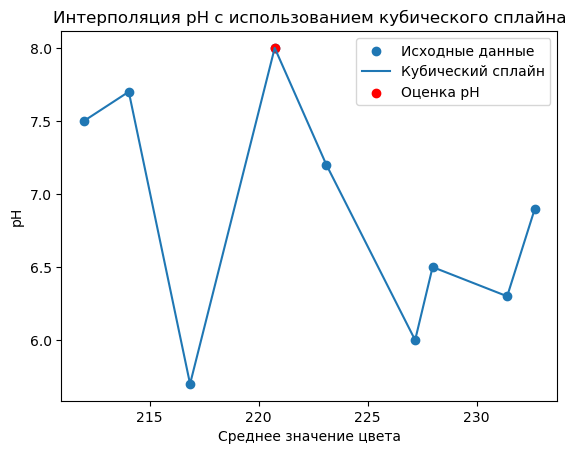

In [19]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Переводим RGB значения в одномерное пространство для упрощения (например, среднее значение)
rgb_mean_values = np.array([np.mean(rgb) for rgb in test_samples.keys()])
ph_values = np.array(list(test_samples.values()))

# Сортировка данных по возрастанию среднего цвета
sorted_indices = np.argsort(rgb_mean_values)
rgb_mean_values_sorted = rgb_mean_values[sorted_indices]
ph_values_sorted = ph_values[sorted_indices]

# Создание функции кубического сплайна
cs = CubicSpline(rgb_mean_values_sorted, ph_values_sorted)

# Использование сплайна для интерполяции pH на основе среднего цвета изображения
mean_rgb_value = np.mean(mean_color)
estimated_ph = cs(mean_rgb_value)

# Вывод результата
print(f"Оценочное значение pH: {estimated_ph:.2f}")

# Опционально: визуализация кубического сплайна
plt.scatter(rgb_mean_values_sorted, ph_values_sorted, label='Исходные данные')
plt.plot(rgb_mean_values_sorted, cs(rgb_mean_values_sorted), label='Кубический сплайн')
plt.scatter(mean_rgb_value, estimated_ph, color='red', label='Оценка pH')
plt.legend()
plt.xlabel('Среднее значение цвета')
plt.ylabel('pH')
plt.title('Интерполяция pH с использованием кубического сплайна')
plt.show()


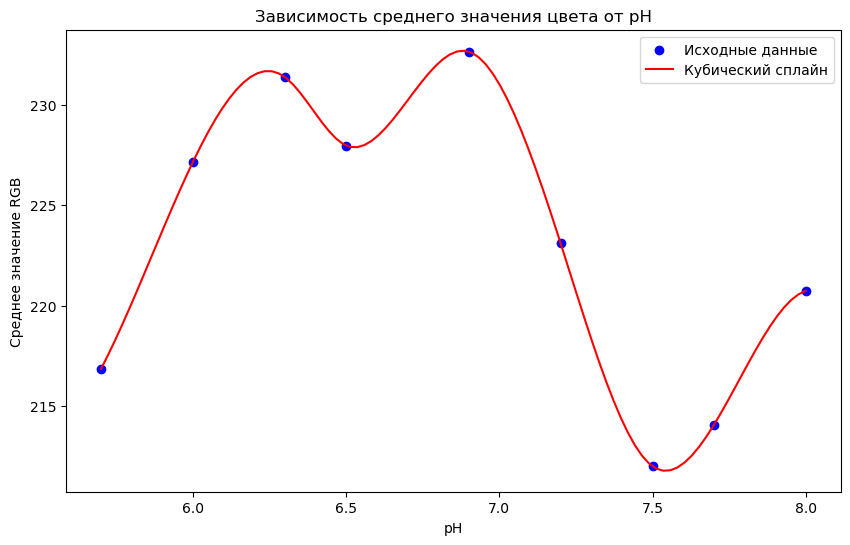

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Сначала убедимся, что значения pH упорядочены по возрастанию для `CubicSpline`
# Это должно быть уже выполнено в предыдущем коде, но проверим и упорядочим еще раз для надежности
ph_values_sorted, rgb_mean_values_sorted = zip(*sorted(zip(ph_values, rgb_mean_values)))

# Теперь `ph_values_sorted` строго возрастают, и мы можем безопасно использовать их для создания сплайна
cs = CubicSpline(ph_values_sorted, rgb_mean_values_sorted)

# Определение диапазона pH для генерации данных сплайна
ph_range = np.linspace(min(ph_values_sorted), max(ph_values_sorted), 100)

# Генерация значений сплайна
rgb_interpolated = cs(ph_range)

# Визуализация интерполированных значений
plt.figure(figsize=(10, 6))
plt.scatter(ph_values_sorted, rgb_mean_values_sorted, c='blue', label='Исходные данные')
plt.plot(ph_range, rgb_interpolated, 'r-', label='Кубический сплайн')
plt.title('Зависимость среднего значения цвета от pH')
plt.xlabel('pH')
plt.ylabel('Среднее значение RGB')
plt.legend()
plt.show()
